In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [2]:
def get_waiting_time(min_wait_time, anom_diff_exp):
    
    R = np.random.uniform(0,1)
    waiting_time = min_wait_time / (R**(1/anom_diff_exp))
    
    return waiting_time

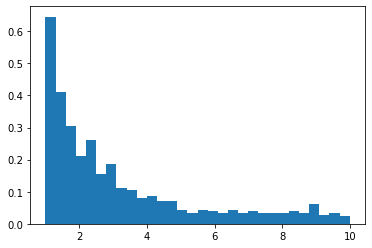

In [3]:
def check_waiting_times(nsamples, alpha, plot_range=None, min_waiting_time=1):
    # plotting probability distribution of waiting times as a check
    waiting_times = np.empty((nsamples))
    for i in range(nsamples):
        waiting_times[i] = get_waiting_time(min_waiting_time, alpha)
    plt.figure()
    plt.hist(waiting_times, bins=30, range=plot_range, density=True)

check_waiting_times(1000, 0.5)
check_waiting_times(1000, 0.5, plot_range=(1,10))

In [4]:
def gaussian_step(D, t, ndim=1):
    
    var = 2*ndim*D*t
    dx = np.random.normal(scale=np.sqrt(var))
    return dx

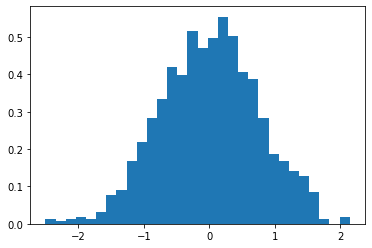

In [5]:
def check_steps(nsamples, D_coeff, t):
    # plotting probability distribution of step lengths as a check

    step_lengths = np.empty((nsamples))
    for i in range(nsamples):
        step_lengths[i] = gaussian_step(D_coeff, t)
    plt.figure()
    plt.hist(step_lengths, bins=30, density=True)
    
check_steps(1000,2.8e11,1e-12)

In [6]:
# CTRW for single particle in 1D
def ctrw(x_start, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp, plot=0):
    """
    Be consistent with units
    run_time: simulation time 
    diff_time: diffusion time
    min_wait_time: minimum waiting time
    """
    time = 0
    x = x_start
    times = np.array([time])
    xs = np.array([x])
    while time < run_time:
        waiting_time = get_waiting_time(min_wait_time, anom_diff_exp)
        time += waiting_time
        times = np.append(times, time)
        xs = np.append(xs, xs[-1])
        x += gaussian_step(diff_coeff, diff_time)
        times = np.append(times, time)
        xs = np.append(xs, x)
    
    # correction so run time not exceeded
    times = times[:-2]
    xs = xs[:-2]
    times = np.append(times, run_time)
    xs = np.append(xs, xs[-1])
    
    data = {'t': times, 'x': xs}
    df = pd.DataFrame(data)
    if plot==1:
        %matplotlib inline
        plt.figure(figsize=(12,10))
        plt.plot(df['t'], df['x'])
        plt.xlabel('time (s)')
        plt.ylabel('x position')
        plt.title('1D CTRW')
    return df

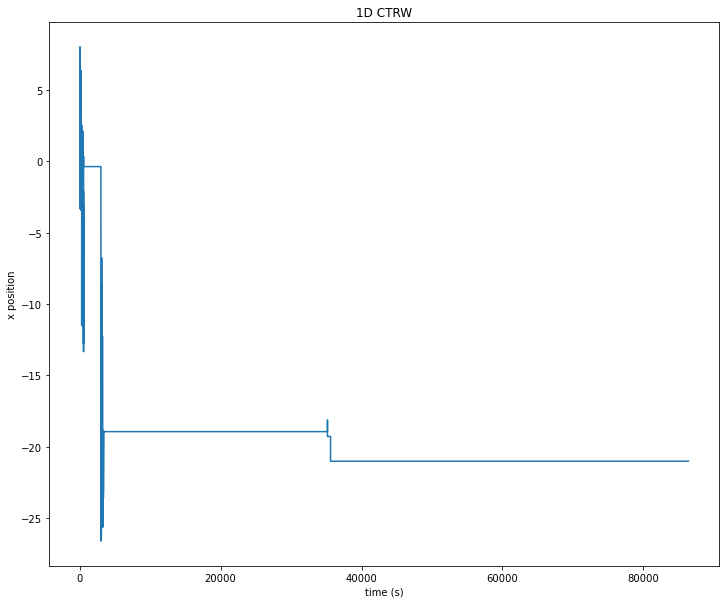

In [7]:
alpha = 0.5
D = 2.8e11  # nm^2/s
t = 1e-12  # jump time in s
A = 0.001  # minimum waiting time in s
run_t = 86400  # simulation run time in s

df = ctrw(0, D, t, run_t, A, alpha, plot=1)

In [8]:
def ctrw_3d(initial_position, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp, plot=0):
    """
    """
    time = 0
    x, y, z = initial_position
    times = np.array([time])
    xs = np.array([x])
    ys = np.array([y])
    zs = np.array([z])
    
    while time < run_time:
        waiting_time = get_waiting_time(min_wait_time, anom_diff_exp)
        time += waiting_time  # update current time
        times = np.append(times, time)
        xs = np.append(xs, xs[-1])
        ys = np.append(ys, ys[-1])
        zs = np.append(zs, zs[-1])
        x += gaussian_step(diff_coeff, diff_time)  # update current x position
        y += gaussian_step(diff_coeff, diff_time)  # update current y position
        z += gaussian_step(diff_coeff, diff_time)  # update current z position
        times = np.append(times, time)
        xs = np.append(xs, x)
        ys = np.append(ys, y)
        zs = np.append(zs, z)
    
    # correction so run time not exceeded
    times = times[:-2]
    xs = xs[:-2]
    ys = ys[:-2]
    zs = zs[:-2]
    times = np.append(times, run_time)
    xs = np.append(xs, xs[-1])
    ys = np.append(ys, ys[-1])
    zs = np.append(zs, zs[-1])
    
    data = {'t': times, 'x': xs, 'y': ys, 'z': zs}
    df = pd.DataFrame(data)
                      
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df['x'], df['y'], df['z'], c='k')
        ax.scatter(df['x'][0], df['y'][0], df['z'][0], c='g')
        ax.scatter(df['x'].iat[-1], df['y'].iat[-1], df['z'].iat[-1], c='r')
    return df

In [9]:
alpha = 0.5
D = 2.8e11  # nm^2/s
t = 1e-12  # jump time in s
A = 0.001  # minimum waiting time in s
run_t = 86400  # simulation run time in s

ctrw_3d((0,0,0), D, t, run_t, A, alpha, plot=1)

<IPython.core.display.Javascript object>

t          x          y          z
0         0.000000   0.000000   0.000000   0.000000
1         0.018706   0.000000   0.000000   0.000000
2         0.018706   1.512216   0.187953   0.022403
3         0.020435   1.512216   0.187953   0.022403
4         0.020435   0.834429   1.127790   0.075246
...            ...        ...        ...        ...
1603   6430.037367  20.709148 -21.534637  44.143665
1604   6430.037367  20.506970 -21.849976  46.114814
1605   6430.038527  20.506970 -21.849976  46.114814
1606   6430.038527  20.590709 -22.887342  46.017489
1607  86400.000000  20.590709 -22.887342  46.017489

[1608 rows x 4 columns]

In [10]:
def gauss_step_3d(xyz_array, diff_coeff, diff_time):
    
    new_coords = np.zeros(3)
    
    xyz_array_row = xyz_array[-1]
    
    xyz_array = np.vstack((xyz_array, xyz_array_row))

    for i,x_i in enumerate(xyz_array_row):
        
        new_coords[i] = x_i + gaussian_step(diff_coeff,diff_time)
        
    xyz_array = np.vstack((xyz_array,new_coords))
    return xyz_array

def get_distance_3d(xyz_array1,xyz_array2):
    #function to get distance between two sets of coordinates
    
    distance = 0
    
    for i,x_i in enumerate(xyz_array1):
        
        distance += (x_i - (xyz_array2[i]))**2
        
    return np.sqrt(distance)

def interaction_process(p):
    #simple call to uniform function if within distance
    #could be altered to consider probability based on distance
    repair = 0 
    q = np.random.uniform(0,1)
    if q < p:
        repair = 1
    return repair

def get_halfway(xyz_array1,xyz_array2):
    
    halfway_coords = np.empty(3)
    
    for i,x_i in enumerate(xyz_array1):
        
        halfway_coords[i] = (x_i + xyz_array2[i])/2
        
    return halfway_coords


In [12]:
def ctrw_3d_interaction(initial_pos, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,
                        int_length, interaction_p=0.5, plot=0, return_trajectories=False):
    """
    initial_pos: 2d array e.g. [(x1,y1,z1), (x2,y2,z2)]
    """
    repair = 0 
    time1 = 0
    time2 = 0 
    
    x1, y1, z1 = initial_pos[0]
    x2, y2, z2 = initial_pos[1]
    
    times1 = np.array([time1])
    times2 = np.array([time2])
    
    coords1 = np.array([[x1, y1, z1]])
    coords2 = np.array([[x2, y2, z2]])
    
    interaction_coords = np.array([[0,0,0,0,0,0]])
    interaction_times = np.array([0])
    interaction_count = 0
    int_count_arr = np.array(interaction_count)
    repair_arr = np.array([repair])
    
    #######################################
    # both particles take an initial step
    """
    if len(times1)==1 and len(times2)==1:
        
        waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
        time1 += waiting_time1
        times1 = np.append(times1, time1)
        times1 = np.append(times1, time1)
        coords1 = gauss_step_3d(coords1, diff_coeff, diff_time)
        
        waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        time2 += waiting_time2
        times2 = np.append(times2, time2)
        times2 = np.append(times2, time2)
        coords2 = gauss_step_3d(coords2, diff_coeff, diff_time)
        
        if waiting_time1 < waiting_time2:
            
            distance = get_distance_3d(coords1[-1], coords2[0]) ####### THIS SEEMS ODD 
            if distance < int_length:
                interaction_count += 1
                int_coords_temp = np.append(coords1[-1], coords2[0])
                repair = interaction_process(interaction_p)
                int_time = time1
                interaction_times = np.array([int_time])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])

            distance = get_distance_3d(coords1[-1],coords2[-1]) ### What is the reason for checking both these parts?
            if distance < int_length:
                interaction_count += 1
                int_coords_temp = np.append(coords1[-1],coords2[-1])
                repair = interaction_process(interaction_p)
                int_time = time2
                if interaction_count == 1:
                    interaction_times = np.array([int_time])
                    interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                    interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                    int_count_arr = np.array([interaction_count])
                    repair_arr = np.array([repair])
                else: 
                    interaction_times = np.vstack((interaction_times,np.array([int_time])))
                    interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                    int_count_arr = np.append(int_count_arr,interaction_count)
                    repair_arr = np.append(repair_arr,repair)
            
        else:
            distance = get_distance_3d(coords1[0], coords2[-1])
            if distance < int_length:
                interaction_count += 1
                int_coords_temp = np.append(coords1[0], coords2[-1])
                repair = interaction_process(interaction_p)
                int_time = time2
                interaction_times = np.array([int_time])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
            
            distance = get_distance_3d(coords1[-1],coords2[-1])
            if distance < int_length:
                interaction_count += 1
                int_coords_temp = np.append(coords1[-1],coords2[-1])
                repair = interaction_process(interaction_p)
                int_time = time1
                if interaction_count == 1:
                    interaction_times = np.array([int_time])
                    interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                    interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                    int_count_arr = np.array([interaction_count])
                    repair_arr = np.array([repair])
                else: 
                    interaction_times = np.vstack((interaction_times,np.array([int_time])))
                    interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                    int_count_arr = np.append(int_count_arr,interaction_count)
                    repair_arr = np.append(repair_arr,repair)
    """
    ########################################
    
    while (time1 < run_time and time2 < run_time) and repair==0:
        
        # the particle that is behind in time takes a step
        if time1 < time2:
            waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
            time1 += waiting_time1
            times1 = np.append(times1, time1)
            times1 = np.append(times1, time1)
            coords1 = gauss_step_3d(coords1, diff_coeff, diff_time)
        else:
            waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
            time2 += waiting_time2
            times2 = np.append(times2, time2)
            times2 = np.append(times2, time2)
            coords2 = gauss_step_3d(coords2, diff_coeff, diff_time)
        
        distance = get_distance_3d(coords1[-1],coords2[-1])
        
        if distance < int_length:
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            if time1 < time2 and time1!=0:
                int_time = time1
            else:
                int_time = time2
            
            if interaction_count == 1:
                interaction_times = np.array([int_time])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([int_time])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)
    
    #######################################
    
    if repair==1:
        # record final position at time of repair 
        if time1 > time2:
            times2 = np.append(times2, time1)
            coords2 = np.vstack((coords2, coords2[-1]))
        else:
            times1 = np.append(times1, time2)
            coords1 = np.vstack((coords1, coords1[-1]))
    
    if repair==0:
        # correction so run time not exceeded
        if time1 > run_time:
            times1 = times1[:-2]
            coords1 = coords1[:-2]
        if time2 > run_time:
            times2 = times2[:-2]
            coords2 = coords2[:-2]
        if times1[-1] < run_time:
            times1 = np.append(times1, run_time)
            coords1 = np.vstack((coords1, coords1[-1]))
        if times2[-1] < run_time:
            times2 = np.append(times2, run_time)
            coords2 = np.vstack((coords2, coords2[-1]))
    
    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    if plot==1:              
        %matplotlib notebook
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.set_title('Interaction count: {},   Repair: {} \n Ran for {} s'.format(interaction_count, repair, times1[-1]))
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')
        ax.set_zlabel('z (nm)')
        ax.scatter(df1['x'][0], df1['y'][0], df1['z'][0], marker='x', c='lime')
        ax.scatter(df2['x'][0], df2['y'][0], df2['z'][0], marker='x', c='lime')
        ax.scatter(df1['x'].iat[-1], df1['y'].iat[-1], df1['z'].iat[-1], marker='x', c='red')
        ax.scatter(df2['x'].iat[-1], df2['y'].iat[-1], df2['z'].iat[-1], marker='x', c='red')
        if interaction_count > 1:
            for i, coords in enumerate(interaction_coords):
                ax.plot3D([coords[0], coords[3]], [coords[1], coords[4]], [coords[2], coords[5]], c='k', ls='dotted')
                if repair==1 and i==interaction_count-1:
                    ax.plot3D([coords[0], coords[3]], [coords[1], coords[4]], [coords[2], coords[5]], c='m', ls='dashed')

    if return_trajectories:
        return interaction_times, interaction_coords, int_count_arr, repair_arr, df1, df2
    else:
        return interaction_times, interaction_coords, int_count_arr, repair_arr
            

In [13]:
#min_dist  = 50  # in nm
interaction_range = 50  # in nm 
interaction_probability = 0.1

alpha = 0.5
D = 2.8e11  # nm^2/s
jump_t = 1e-12  # jump time in s
min_t = 0.1  # minimum waiting time in s
run_t = 86400  # simulation run time in s

ts,xyzs,counts,repair,df1,df2 = ctrw_3d_interaction([(0,0,0),(0,0,interaction_range*1.5)], D, jump_t, run_t, min_t, alpha,
                                                    interaction_range, interaction_p=interaction_probability,
                                                    plot=1, return_trajectories=True)

<IPython.core.display.Javascript object>

In [15]:
def ctrw_3d_interaction_mc(nsamples, initial_pos, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,
                           int_length, interaction_p=0.5, plot=0):
    
    j = 0
    
    for i in np.arange(nsamples):
        
        ts_temp,xyzs_temp,counts_temp,repair_temp = ctrw_3d_interaction(initial_pos, diff_coeff, diff_time, run_time,
                                                                        min_wait_time, anom_diff_exp, 
                                                                        int_length, interaction_p=interaction_p, plot=plot)
     
        repair_temp = np.reshape(repair_temp,(len(repair_temp),1))
        counts_temp = np.reshape(counts_temp,(np.size(counts_temp),1))
        
        if counts_temp[0] != 0:
        
            mc_sample = np.full((len(counts_temp),1),i)

            data_temp = np.hstack((mc_sample,ts_temp,xyzs_temp,counts_temp,repair_temp))

            if j == 0:
                repair_data = data_temp

            else: 
                repair_data = np.vstack((repair_data,data_temp))
                
            j+=1
                
    if j != 0:
        repair_df = pd.DataFrame(data=repair_data, columns=['mc_step', 't','x1','y1','z1','x2','y2','z2','interaction','repair'])
    
    else:
        repair_df = pd.DataFrame()
        
    return repair_df
    

In [16]:
repair_data = ctrw_3d_interaction_mc(100,[(0,0,0),(0,0,interaction_range*1)], D, jump_t, run_t, min_t, 0.5,
                                       interaction_range,interaction_p = 0.1,plot=0)

In [17]:
repair_data

mc_step            t        x1        y1        z1        x2        y2  \
0        0.0  1430.234526  4.656803 -3.817378  6.900161  1.375211 -5.447483   
1        0.0  1430.591204  4.002941 -5.212948  7.507527  1.375211 -5.447483   
2        0.0  1431.322580  3.338561 -4.804236  8.441946  1.375211 -5.447483   
3        0.0  1434.314663  3.661103 -5.727927  8.106931  1.375211 -5.447483   
4        0.0  1440.797971  3.230506 -6.945602  9.057129  1.375211 -5.447483   
..       ...          ...       ...       ...       ...       ...       ...   
768     99.0     8.558187  0.484343  0.460202  1.781464  1.060651 -0.066446   
769     99.0    13.390065  0.983839  1.078402  0.940362  1.060651 -0.066446   
770     99.0    26.332794  2.383261  0.535682  0.278674  1.060651 -0.066446   
771     99.0    26.633437  1.549973 -0.313389  0.077387  1.060651 -0.066446   
772     99.0    28.771116  3.212879  0.673447  0.351764  1.060651 -0.066446   

            z2  interaction  repair  
0    56.139954          1.0     0.0  
1    56.139954          2.0     0.0  
2    56.139954          3.0     0.0  
3    56.139954          4.0     0.0  
4    56.139954          5.0     0.0  
..         ...          ...     ...  
768  49.781521          6.0     0.0  
769  49.781521          7.0     0.0  
770  49.781521          8.0     0.0  
771  49.781521          9.0     0.0  
772  49.781521         10.0     1.0  

[773 rows x 10 columns]

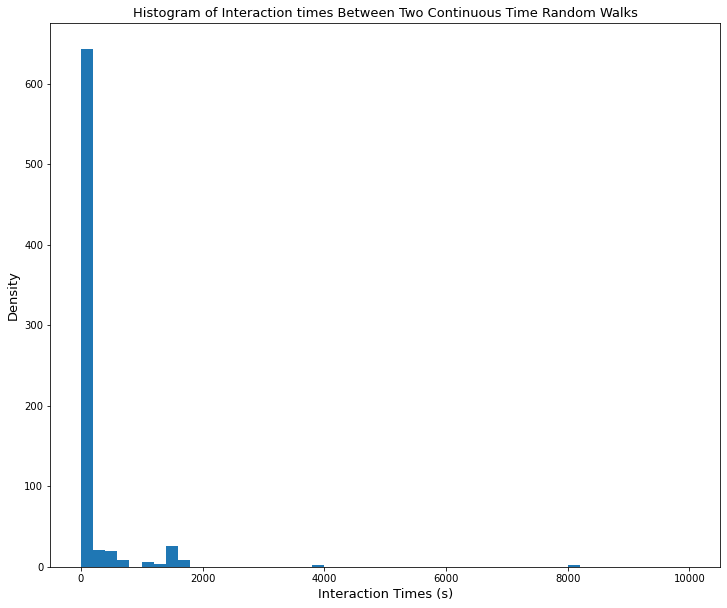

In [18]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,10))
ax.hist(repair_data['t'], bins=50,range=(0,10000))
ax.set_xlabel('Interaction Times (s)',fontsize=13)
ax.set_ylabel('Density',fontsize=13)
plt.title('Histogram of Interaction times Between Two Continuous Time Random Walks',fontsize=13)

plt.show()

In [19]:
repair_events = repair_data[repair_data['repair']==1.0]
repair_count = repair_events['interaction']
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(repair_count,bins='auto',range=(0,max(repair_count)))
ax.set_xlabel('Number of Interactions',fontsize=13)
ax.set_ylabel('Density',fontsize=13)
plt.title('Histogram of Number of Interactions Before Repair\n (Interaction Probability {})'.format(interaction_probability),
          fontsize=13)

print('Repaired {} / {} within run time {} s'.format(len(repair_events), 1+int(repair_data['mc_step'].iat[-1]), run_t))
print('Mean no. of interactions before repair: {:.3f}'.format(np.mean(repair_count)))

Repaired 91 / 100 within run time 86400 s
Mean no. of interactions before repair: 7.912


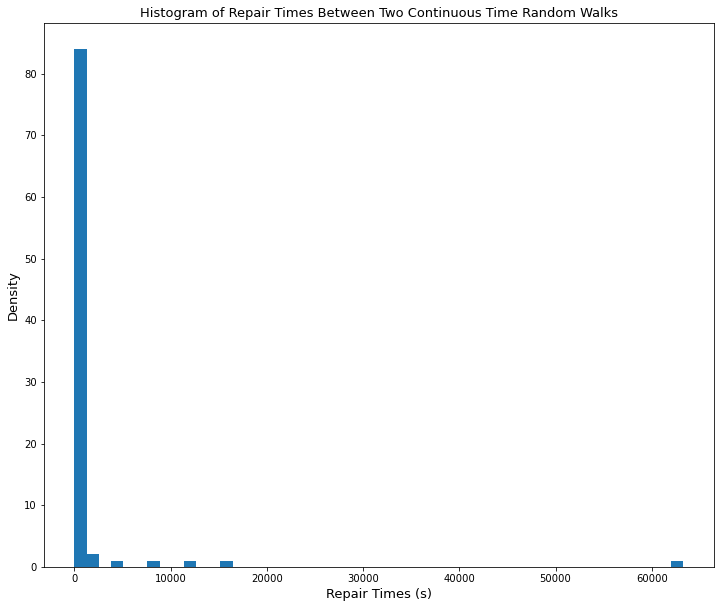

In [20]:
fig,ax = plt.subplots(figsize=(12,10))
repair_times = repair_events['t']
ax.hist(repair_times,bins=50)
ax.set_xlabel('Repair Times (s)',fontsize=13)
ax.set_ylabel('Density',fontsize=13)
plt.title('Histogram of Repair Times Between Two Continuous Time Random Walks',fontsize=13)

plt.show()

In [25]:
def ctrw_interaction_mc_D(nsamples_per_D, repeats, initial_pos, diff_coeffs, diff_time, run_time, min_wait_time, anom_diff_exp,
                          int_length, interaction_p=0.5, plot=0):
    
    repair_avgs = np.empty(len(diff_coeffs))
    repair_stds = np.empty(len(diff_coeffs))
    
    for k,D in enumerate(diff_coeffs):
        
        temp_repair_rates = np.empty(repeats)
        
        for i in np.arange(repeats):
#             data = ctrw_3d_interaction_mc(nsamples_per_D, initial_pos, D, t, run_t, A, 0.5,
#                                            int_length,interaction_p = interaction_p,plot=plot)
            data = ctrw_3d_interaction_mc(nsamples_per_D, initial_pos, D, diff_time, run_time, min_wait_time, anom_diff_exp,
                                          int_length, interaction_p=interaction_p, plot=plot)
           # print(data)
            if len(data.index) == 0:
                temp_repair_rates[i] = np.NaN
            else:  
                repair_events = len(data[data['repair']==1.0])
                temp_repair_rates[i] = repair_events
            
        repair_avgs[k] = np.nanmean(temp_repair_rates)
        repair_stds[k] = np.nanstd(temp_repair_rates)
        
    return repair_avgs, repair_stds

def ctrw_interaction_mc_D_r(nsamples_per_D, repeats, separations, diff_coeffs, diff_time, run_time, min_wait_time, anom_diff_exp,
                           int_length, interaction_p=0.5, plot=0):
    
    N_rows = int(len(diff_coeffs)*len(separations))
    print(N_rows)
    
    repair_data_D_r = np.empty((N_rows,4)) 

    
    for j,r in enumerate(separations):
        
        print('-----')
        
        initial_pos = [(0,0,0),(0,0,r)]
                                 
        repair_avgs = np.empty(len(diff_coeffs))
        repair_stds = np.empty(len(diff_coeffs))
    
        for k,D in enumerate(diff_coeffs):
            
            print(j*len(diff_coeffs)+k)
            print(r,D)

            temp_repair_rates = np.empty(repeats)

            for i in np.arange(repeats):
                
                data = ctrw_3d_interaction_mc(nsamples_per_D, initial_pos, D, diff_time, run_time, min_wait_time, anom_diff_exp,
                                              int_length, interaction_p=interaction_p, plot=plot)
               # print(data)
                if len(data.index) == 0:

                    temp_repair_rates[i] = 0
                else:  
                    repair_events = len(data[data['repair']==1.0])
                    temp_repair_rates[i] = repair_events

            repair_avg = np.nanmean(temp_repair_rates)
            repair_std = np.nanstd(temp_repair_rates)
            
            repair_data_row = np.array([r,D,repair_avg,repair_std])
            repair_data_D_r[j*len(diff_coeffs)+k] = repair_data_row

            
    repair_df_D_r = pd.DataFrame(data=repair_data_D_r, columns=['r','D','Repair Rate','Repair Rate Std'])                 
        
    return repair_df_D_r

In [26]:
D_vals = 2.8*np.logspace(7,17,num=11)
repair_avgs,repair_stds = ctrw_interaction_mc_D(50,3,[(0,0,0),(0,0,interaction_range)], D_vals, jump_t, run_t, min_t, 0.5,
                                                interaction_range)

<ipython-input-25-d7f3f8c188df>:23: RuntimeWarning: Mean of empty slice
  repair_avgs[k] = np.nanmean(temp_repair_rates)
C:\Users\PaulV\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [27]:
print(repair_avgs,repair_stds)

[47.33333333 47.33333333 48.         47.33333333 44.66666667 45.66666667
 40.66666667 23.66666667  4.66666667  0.                 nan] [0.47140452 1.88561808 0.         2.05480467 1.24721913 2.05480467
 2.62466929 2.05480467 1.69967317 0.                nan]


<IPython.core.display.Javascript object>


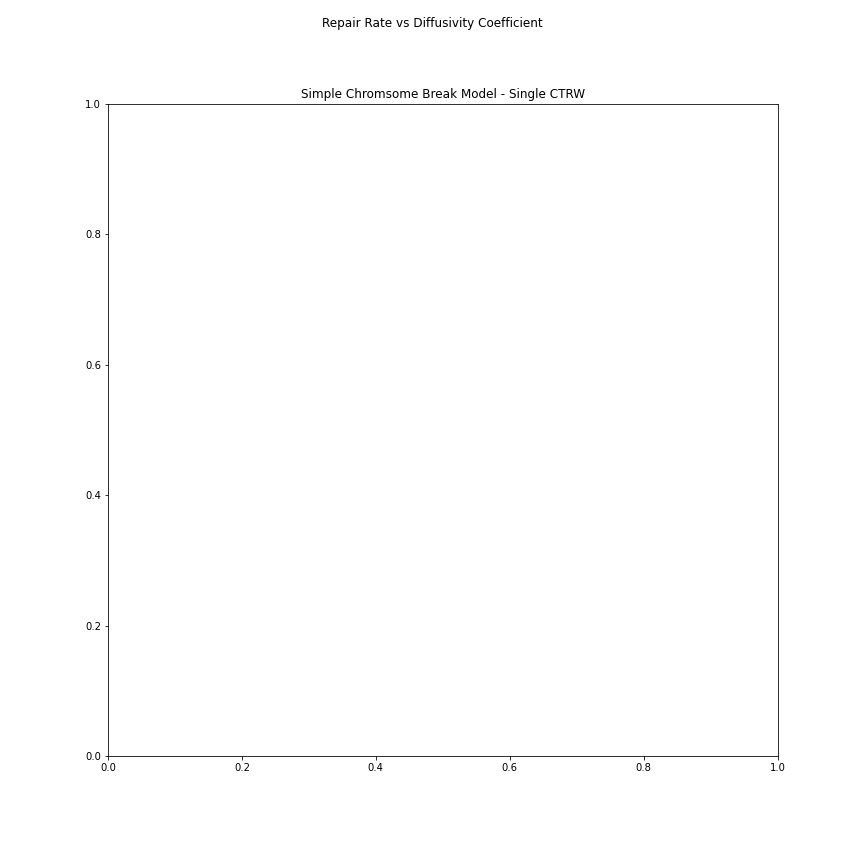

ValueError: 'x' and 'y' must have the same size

In [68]:
fig,ax = plt.subplots(figsize=(12,12))
plt.suptitle('Repair Rate vs Diffusivity Coefficient')
plt.title('Simple Chromsome Break Model - Single CTRW')
plt.errorbar(x=D_vals,y=repair_avgs/50,yerr=repair_stds/50)
#plt.bar(D_vals, repair_avgs, color ='maroon',width = 0.4)
ax.set_xscale('log')
ax.set_xlabel('Diffusivity Coefficient')

plt.fill_between(
        x= D_vals, 
        y1= repair_avgs/50, 
        where= (10e6 <= D_vals)&(D_vals < 10e16),
        color= "b",
        alpha= 0.2)

ax.set_ylabel('Repair Rate')

In [42]:
r_vals = np.arange(interaction_range*0.5,interaction_range*3.5,0.5*interaction_range)
D_vals = 2.8*np.logspace(7,16,num=10)

repair_df_D_r = ctrw_interaction_mc_D_r(50, 3, r_vals, D_vals, jump_t, run_t, min_t, 0.5,interaction_range, interaction_p = 0.1)

60
-----
0
25.0 28000000.0
1
25.0 280000000.0
2
25.0 2800000000.0
3
25.0 28000000000.0
4
25.0 280000000000.0
5
25.0 2800000000000.0
6
25.0 28000000000000.0
7
25.0 279999999999999.97
8
25.0 2800000000000000.0
9
25.0 2.8e+16
-----
10
50.0 28000000.0
11
50.0 280000000.0
12
50.0 2800000000.0
13
50.0 28000000000.0
14
50.0 280000000000.0
15
50.0 2800000000000.0
16
50.0 28000000000000.0
17
50.0 279999999999999.97
18
50.0 2800000000000000.0
19
50.0 2.8e+16
-----
20
75.0 28000000.0
21
75.0 280000000.0
22
75.0 2800000000.0
23
75.0 28000000000.0
24
75.0 280000000000.0
25
75.0 2800000000000.0
26
75.0 28000000000000.0
27
75.0 279999999999999.97
28
75.0 2800000000000000.0
29
75.0 2.8e+16
-----
30
100.0 28000000.0
31
100.0 280000000.0
32
100.0 2800000000.0
33
100.0 28000000000.0
34
100.0 280000000000.0
35
100.0 2800000000000.0
36
100.0 28000000000000.0
37
100.0 279999999999999.97
38
100.0 2800000000000000.0
39
100.0 2.8e+16
-----
40
125.0 28000000.0
41
125.0 280000000.0
42
125.0 2800000000.0
43
125.0

In [62]:
print(len(r_vals))

6


In [61]:
print(len(D_vals),len(r_vals))
repair_df_D_r[repair_df_D_r['r']==25.0]['Repair Rate']

10 6


0    49.666667
1    49.000000
2    49.666667
3    49.666667
4    49.000000
5    48.666667
6    41.333333
7    11.000000
8     1.333333
9     0.000000
Name: Repair Rate, dtype: float64

<IPython.core.display.Javascript object>


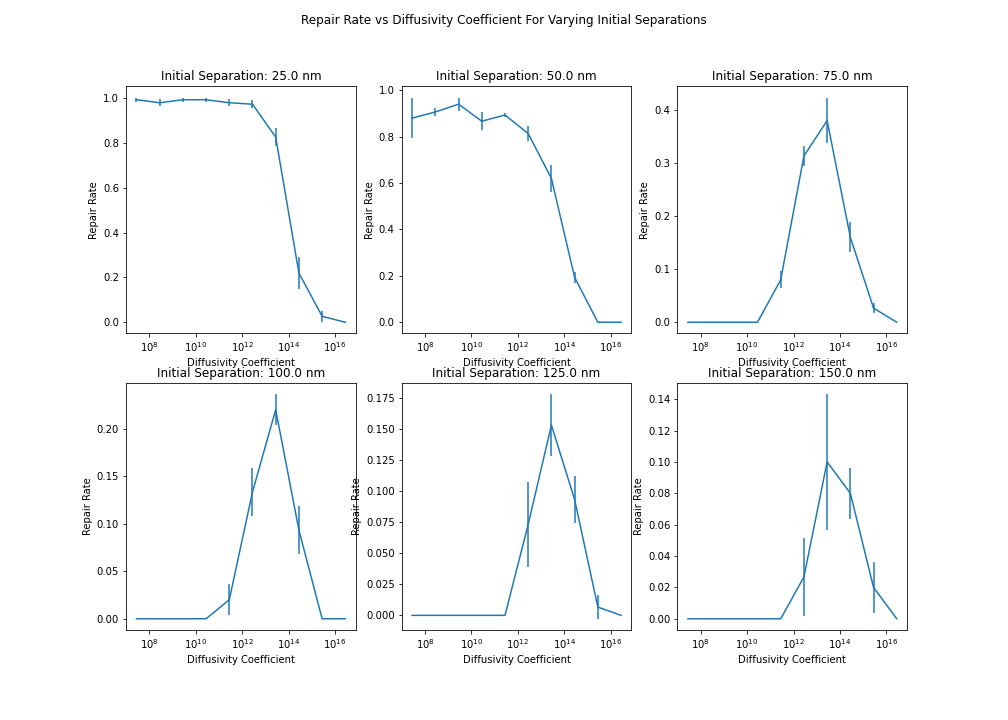

<IPython.core.display.Javascript object>


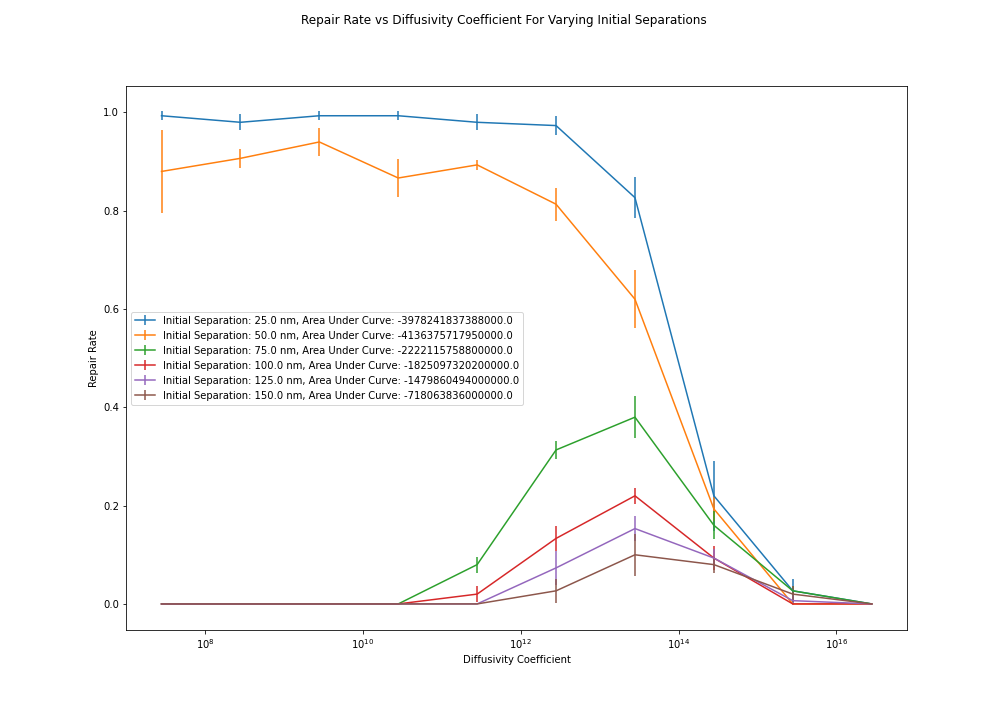

In [89]:
def plot_3d(repair_df_D_r, r_vals,D_vals,reps):
    
   # h_dict = get_dict_from_file(file_name, window, all_step_sizes, restriction)
    
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.plasma
    
    steps = [int(r) for r in r_vals]
    
    for i,r in enumerate(r_vals):
        ytick = r
        
        #temp_counts = norm_counts[i]
        #temp_bins = bins[i]
        #xcenter = np.convolve(temp_bins, np.ones(2), "valid")/2
        #xwidth = np.diff(temp_bins)
        
        #ax.bar(left=xcenter, height=temp_counts, width=xwidth, zs=ytick,
         #      zdir="y", color=cmap(i/len(yticks)), alpha=0.7, edgecolor="grey", linewidth=0.3)
        
        print(len(D_vals),len(repair_avgs))
        data = repair_df_D_r[repair_df_D_r['r']==r]
        
        ax.errorbar(x=data['D'],y=data['Repair Rate']/reps,yerr=data['Repair Rate Std']/reps,color=cmap(i/len(r_vals)))
        
        ax.set_xscale('log')
        ax.set_xlabel('Diffusivity Coefficient')

        plt.fill_between(
                x= data['D'], 
                y1= data['Repair Rate']/reps ,
                where= (10e6 <= data['D'])&(data['D'] < 10e16),
                color= "b",
                alpha= 0.2)

        ax.set_ylabel('Repair Rate')
        ax.set_xscale('log')
        ax.set_xlabel('Diffusivity Coefficient')


    ax.set_ylabel("Initial Separation")
    ax.set_zlabel("Repair Rate")

    ax.set_yticks(r_vals)
    plt.show()
    

def plot_r_and_D_subplots(repair_df_D_r,reps,r_vals):
    
    fig,axes = plt.subplots(2,3,figsize=(14,10))
    plt.suptitle('Repair Rate vs Diffusivity Coefficient For Varying Initial Separations')
    for i,r in enumerate(r_vals):

        data = repair_df_D_r[repair_df_D_r['r']==r]

        axes.flat[i].errorbar(x=data['D'],y=data['Repair Rate']/reps,yerr=data['Repair Rate Std']/reps)
        axes.flat[i].set_xscale('log')
        axes.flat[i].set_xlabel('Diffusivity Coefficient')
        axes.flat[i].set_ylabel('Repair Rate')
        
        axes.flat[i].set_title('Initial Separation: {} nm'.format(r))
    
def plot_r_and_D(repair_df_D_r,reps,r_vals):
    
    fig,ax = plt.subplots(figsize=(14,10))
    plt.suptitle('Repair Rate vs Diffusivity Coefficient For Varying Initial Separations')
    for i,r in enumerate(r_vals):

        data = repair_df_D_r[repair_df_D_r['r']==r]

        area = scipy.integrate.simpson(data['Repair Rate']/reps, x=data['D'], axis=-1, even='avg')
        ax.errorbar(x=data['D'],y=data['Repair Rate']/reps,
                    yerr=data['Repair Rate Std']/reps,label='Initial Separation: {} nm, Area Under Curve: {}'.format(r,area))
        ax.set_xscale('log')
        ax.set_xlabel('Diffusivity Coefficient')
        ax.set_ylabel('Repair Rate')
        ax.legend()
        
        
    
plot_r_and_D_subplots(repair_df_D_r,50,r_vals)
plot_r_and_D(repair_df_D_r,50,r_vals)
    

<IPython.core.display.Javascript object>


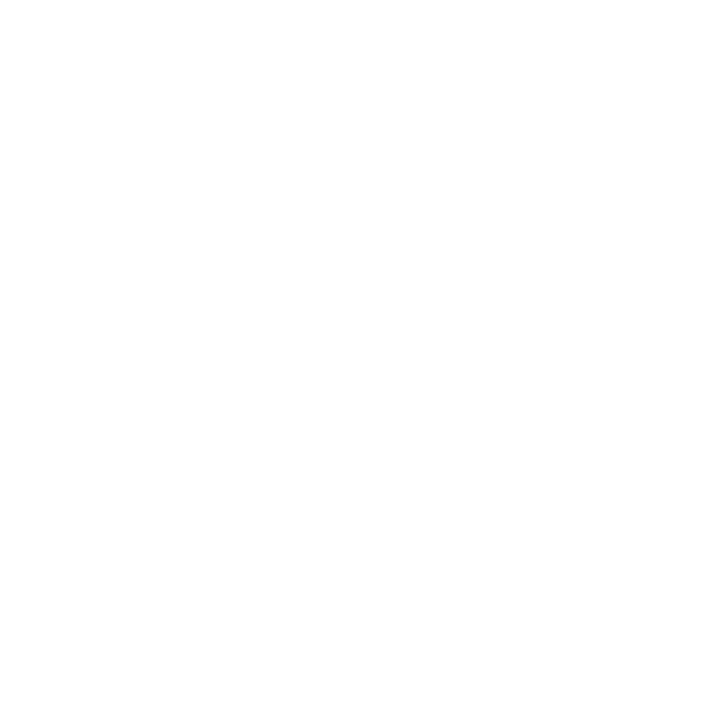

10 11
10 11
10 11
10 11
10 11
10 11


In [83]:
## AT the moment 3D histogram type plot not working, gives an empty plot?
plot_3d(repair_df_D_r,r_vals,D_vals,50)

In [71]:
def unit_vector_single():
    #Streamlined function to return only a single vector, distributed in the same manner as above.
    #Plotting of the above vectors in large quantity attest the validity of using this function.
    
    random_value_1 = np.random.uniform(0,1)
    random_value_2 = np.random.uniform(0,1)
    
    #ICDFs produced as before
    inclination = np.arccos(1-2*random_value_1)
    azimuth = 2*(np.pi)*random_value_2
    
    #cartesian conversion
    x = np.cos(azimuth)*np.sin(inclination)
    y = np.sin(azimuth)*np.sin(inclination)
    z = np.cos(inclination)
    
    return np.array([x,y,z])

def ctrw_3d_self_interaction(initial_pos,diff_coeff,diff_time,run_time,min_wait_time,anom_diff_exp,
                        int_length,strand_length,interaction_p=0.5,plot=0):
    """
    """
    repair = 0 
    time1 = 0
    time2 = 0 
    
    x1, y1, z1 = initial_pos
    x2, y2, z2 = initial_pos + strand_length*unit_vector_single()

    times1 = np.array([time1])
    times2 = np.array([time2])
    
    coords1 = np.array([[x1, y1, z1]])
    coords2 = np.array([[x2, y2, z2]])
    
    interaction_coords = np.array([0,0,0,0,0,0])
    interaction_times = np.array([0])
    interaction_count = 0
    
    int_count_arr = np.array(interaction_count)
    repair_arr = np.array([repair])

    while (time1 < run_time or time2 < run_time) and repair ==0:
        
        """
        waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
        waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        
        time1 += waiting_time1  # update current time
        times1 = np.append(times1, time1)
        
        time2 += waiting_time2  # update current time
        times2 = np.append(times2, time2)
        
        coords1_temp = gauss_step_3d(coords1,diff_coeff, diff_time)
        coords2_temp = gauss_step_3d(coords2,diff_coeff, diff_time)
        
        coords_temp = np.array([coords1_temp,coords2_temp])
        """
        coords1_temp = coords1
        coords2_temp = coords2
        
        # the particle that is behind in time takes a step
        if time1 < time2:
            waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
            time1 += waiting_time1
            times1 = np.append(times1, time1)
            times1 = np.append(times1, time1)
            coords1 = gauss_step_3d(coords1, diff_coeff, diff_time)
        else:
            waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
            time2 += waiting_time2
            times2 = np.append(times2, time2)
            times2 = np.append(times2, time2)
            coords2 = gauss_step_3d(coords2, diff_coeff, diff_time)
            
        distance = get_distance_3d(coords1[-1],coords2[-1])
        
        coords_tt = np.array([coords1_,coords2])

        while (distance > strand_length):
            
            coords_tt = coords_temp
               
            i = np.random.randint(0,1)
            
            print(coords_tt[i])
            print(coords_temp[i])
               
            coords_tt[i] = gauss_step_3d(coords_temp[i],diff_coeff, diff_time)
            
            print(coords_tt[i])
            print(coords_temp[i])
            
            distance = get_distance_3d(coords_tt[0][-1],coords_tt[1][-1])
            
        coords1,coords2 = coords_tt

        if distance < int_length:
            
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            
            if interaction_count == 1:
                interaction_times = np.array([time1,time2])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([time1,time2])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)


    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    
    """
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.scatter(df1['x'].iloc[0], df1['y'].iloc[0], df1['z'].iloc[0],marker='x',c='k')
        ax.scatter(df2['x'].iloc[0], df2['y'].iloc[0], df2['z'].iloc[0],marker='x',c='k')
        
        if interaction_count > 1:
            ax.scatter(interaction_coords[:-1,0],interaction_coords[:-1,1],
                       interaction_coords[:-1,2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-1,0],interaction_coords[-1,1],
                       interaction_coords[-1,2],c='r')
                
        elif interaction_count == 1:
            ax.scatter(interaction_coords[0],interaction_coords[1],
                       interaction_coords[2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-0],interaction_coords[1],
                       interaction_coords[2],c='r')
                       
    """
        
    return interaction_times,interaction_coords,int_count_arr,repair_arr

In [236]:
def repair_process(interaction_index,interaction_p):
    """
    Updated Function to also cnsider misrepairs
    """
    repair = interaction_process(interaction_p)
    
    #index 0 = i12, index 5 = i34, which are ends of same pair
    # if not these indices, misrepair between diff strands
    if interaction_index != 0 and interaction_index != 5:
    
        repair = repair*(-1)
        
    return repair

def check_interaction(t1,t2,t3,t4,c1,c2,c3,c4,i_range,int_in,int_p):
    """
    Function to take positions, times and check for interactions or repair
    t1-t4 are current walk times, c1-c4 are their coordinates xyz
    i_range is interaction range, int_in is exisiting interaction array
    int_in has form: [[interaction_time,i12,i13,i14,i23,i24,i34,repair]]
    Where i12 is a tally of interactions between 1 and 2 etc, repair is 1,0,-1
    for repair,no repair, or misrepair
    int_p is repair probability
    """
    
    #array of combinations of times and coordinates to iterate through later
    times = np.array([[t1,t2],[t1,t3],[t1,t4],[t2,t3],[t2,t4],[t3,t4]],dtype=object)
    coords = np.array([[c1,c2],[c1,c3],[c1,c4],[c2,c3],[c2,c4],[c3,c4]],dtype=object)
    #distances = np.zeros(6)
    
    #empty array for interaction times for all 6 possible combinations 12,13...34
    interaction_t = np.zeros(6)
    #array with original indices and room for time of interaction, for sorting
    int_i_and_t = np.array([[0,0],[1,0],[2,0],[3,0],[4,0],[5,0]])
    
    for i,cc in enumerate(coords):
        
        distance = get_distance_3d(cc[0],cc[1])
       # distances[i] = distance
        
        if distance < i_range:
            print('!')
            
            int_t = np.min(times[i])
            print(int_t)
            int_i_and_t[i,1] =  int_t
            interaction_t[i]  = int_t
    
    print(int_i_and_t)
    i_sort = np.argsort(interaction_t)
    i_and_t_sorted = int_i_and_t[i_sort]
    
    #int_row_in = [[t,12,13,14,23,24,34,r]]
    #int_row_in[-1] = [t,12,13,14,23,24,34,r]
    int_out_temp = int_in
    int_row_out_temp = int_out_temp[-1]
           
    repair = 0
    jj = 1 
    
    while repair == 0 and jj < 7: 
        
        #print(int_row_out_temp)
        
        i = i_and_t_sorted[jj-1][0]
        t = i_and_t_sorted[jj-1][1]

        #check if interaction actually occured, once repair happens, finish
        if t != 0:
            
            int_row_out_temp[0] = t
            int_row_out_temp[i+1] += 1
            
            repair_temp = repair_process(i,int_p)
            int_row_out_temp[7] = repair_temp
            
            if jj == 1: 
                
                int_out_temp = int_row_out_temp
                
            else:
                
                int_out_temp = np.vstack((int_out_temp,int_row_out_temp))
            
            repair = repair_temp
        
        jj += 1 
        
    #int_out = np.vstack((int_in,int_out_temp))
                 
    return int_out_temp,repair


In [240]:
def step_check_time_f(time1,time2,times1,times2,coords1,coords2,diff_coeff,diff_time,min_wait_time,anom_diff_exp):
    
    if time1 < time2:
        waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
        time1 += waiting_time1
        times1 = np.append(times1, time1)
        times1 = np.append(times1, time1)
        coords1 = gauss_step_3d(coords1, diff_coeff, diff_time)
        
    else:
        waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        time2 += waiting_time2
        times2 = np.append(times2, time2)
        times2 = np.append(times2, time2)
        coords2 = gauss_step_3d(coords2, diff_coeff, diff_time)
        
    
        
    return time1,time2,times1,times2,coords1,coords2

def ctrw_pair(timej,timejj,timesj,timesjj,coordsj,coordsjj,
              diff_coeff,diff_time,min_wait_time,anom_diff_exp):
    
    timej_t,timejj_t,timesj_t,timesjj_t,coordsj_t,coordsjj_t = step_check_time_f(timej,timejj,timesj,timesjj,coordsj,
                                                                                  coordsjj,diff_coeff,diff_time,min_wait_time,
                                                                                  anom_diff_exp)
    distance_j_jj = get_distance_3d(coordsj_t[-1],coordsjj_t[-1])
        
    #repeat increments of time/space until correct spatial dispalcement found
    #distance must be less than strand length
    #Crude implementation currently, ideally just step in space would be recalculated

    while distance_j_jj > strand_length:
        #print('!')
            
        timej_t,timejj_t,timesj_t,timesjj_t,coordsj_t,coordsjj_t = step_check_time_f(time1,time2,times1,times2,coords1,coords2,
                                                                                  diff_coeff,diff_time,min_wait_time,
                                                                                  anom_diff_exp)
            
        distance_j_jj = get_distance_3d(coordsj_t[-1],coordsjj_t[-1])
        
    timej,timejj,timesj,timesjj,coordsj,coordsjj = timej_t,timejj_t,timesj_t,timesjj_t,coordsj_t,coordsjj_t
        
    return timej_t,timejj_t,timesj_t,timesjj_t,coordsj_t,coordsjj_t,distance_j_jj

def get_strand_end_pos(initial_pos,strand_length):
    
    x1, y1, z1 = initial_pos
    x2, y2, z2 = initial_pos + np.random.uniform()*strand_length*unit_vector_single()
    
    return x1,y1,z1,x2,y2,z2

def two_coupled_ctrw(initial_pos, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,
                              int_length,strand_length, interaction_p=0.5):
    """
    initial_pos: 2d array e.g. [(x1,y1,z1), (x2,y2,z2)]
    """
    repair = 0 
    int_t = 0
    
    time1,time2,time3,time4 = 0,0,0,0
    
    x1, y1, z1, x2, y2, z2 = get_strand_end_pos(initial_pos[0],strand_length)
    x3, y3, z3, x4, y4, z4 = get_strand_end_pos(initial_pos[1],strand_length)

    times1 = np.array([time1])
    times2 = np.array([time2])
    times3 = np.array([time3])
    times4 = np.array([time4])
    
    times = np.array([time1,time2,time3,time4])
    
    coords1 = np.array([[x1, y1, z1]])
    coords2 = np.array([[x2, y2, z2]])
    coords3 = np.array([[x3, y3, z3]])
    coords4 = np.array([[x4, y4, z4]])
    
    #possible correct repair counts
    i12,i34 = 0,0
    #possible misrepair counts
    i13,i14,i23,i24 = 0,0,0,0
    
    #interaction_times = np.array([0])
    int_arr = np.array([[int_t,i12,i13,i14,i23,i24,i34,repair]])
    
    while (all(t < run_time for t in times) == True) and (repair == 0):

        time1,time2,times1,times2,coords1,coords2,distance12 = ctrw_pair(time1,time2,times1,times2,coords1,
                                                                         coords2,diff_coeff,diff_time,min_wait_time,
                                                                         anom_diff_exp)
        
        time3,time4,times3,times4,coords3,coords4,distance34 = ctrw_pair(time3,time4,times3,times4,coords3,
                                                                         coords4,diff_coeff,diff_time,min_wait_time,
                                                                         anom_diff_exp)
        c1 = coords1[-1]
        c2 = coords2[-1]
        c3 = coords3[-1]
        c4 = coords4[-1]
        
        int_arr,repair = check_interaction(time1,time2,time3,time4,c1,c2,c3,c4,int_length,int_arr,interaction_p)
        
        
        #print(int_arr)
      
    """
        if distance < int_length:
            
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            if time1 < time2 and time1!=0:
                int_time = time1
            else:
                int_time = time2
            
            if interaction_count == 1:
                interaction_times = np.array([int_time])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([int_time])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)
    
    if repair==1:
        # record final position at time of repair 
        if time1 > time2:
            times2 = np.append(times2, time1)
            coords2 = np.vstack((coords2, coords2[-1]))
        else:
            times1 = np.append(times1, time2)
            coords1 = np.vstack((coords1, coords1[-1]))
    
    if repair==0:
        # correction so run time not exceeded
        if time1 > run_time:
            times1 = times1[:-2]
            coords1 = coords1[:-2]
        if time2 > run_time:
            times2 = times2[:-2]
            coords2 = coords2[:-2]
        if times1[-1] < run_time:
            times1 = np.append(times1, run_time)
            coords1 = np.vstack((coords1, coords1[-1]))
        if times2[-1] < run_time:
            times2 = np.append(times2, run_time)
            coords2 = np.vstack((coords2, coords2[-1]))
            
    
    
    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    if plot==1:              
        %matplotlib notebook
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.set_title('Interaction count: {},   Repair: {} \n Ran for {} s'.format(interaction_count, repair, times1[-1]))
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')
        ax.set_zlabel('z (nm)')
        ax.scatter(df1['x'][0], df1['y'][0], df1['z'][0], marker='x', c='lime')
        ax.scatter(df2['x'][0], df2['y'][0], df2['z'][0], marker='x', c='lime')
        ax.scatter(df1['x'].iat[-1], df1['y'].iat[-1], df1['z'].iat[-1], marker='x', c='red')
        ax.scatter(df2['x'].iat[-1], df2['y'].iat[-1], df2['z'].iat[-1], marker='x', c='red')
        if interaction_count > 1:
            for i, coords in enumerate(interaction_coords):
                ax.plot3D([coords[0], coords[3]], [coords[1], coords[4]], [coords[2], coords[5]], c='k', ls='dotted')
                if repair==1 and i==interaction_count-1:
                    ax.plot3D([coords[0], coords[3]], [coords[1], coords[4]], [coords[2], coords[5]], c='m', ls='dashed')

    if return_trajectories:
        return interaction_times, interaction_coords, int_count_arr, repair_arr, df1, df2
    else:
    """
    return int_arr
            

In [241]:
interaction_range = 50  # in nm 
interaction_probability = 0.1

alpha = 0.5
D = 2.8e11  # nm^2/s
jump_t = 1e-12  # jump time in s
min_t = 0.1  # minimum waiting time in s
run_t = 1000 #86400  # simulation run time in s

int_length = 25
strand_length = 100
separation = 25 

In [242]:
two_coupled_ctrw([(0,0,0),(0,0,separation)], D, jump_t, run_t, min_t, alpha,
                 int_length,strand_length, interaction_p=0.5)

!
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
!
!
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]
!
[[ 0 41]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]]


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [41,  1,  0, ...,  0,  0,  1],
       [41,  1,  0, ...,  0,  0,  1]])

!
!
!
!
!
!
!
!
!
!
!
!


<IPython.core.display.Javascript object>


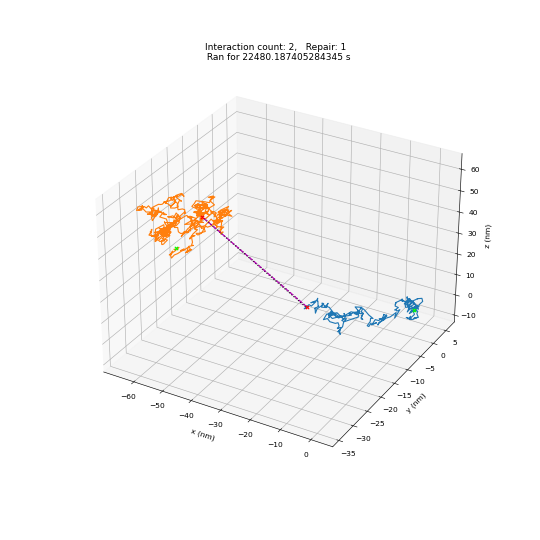

(array([[20315.29557252],
        [20315.41475835]]),
 array([[-23.1810777 , -14.99776436,  10.47447276, -49.97829145,
         -23.18001489,  51.54393108],
        [-22.99518846, -14.81424842,  10.38740558, -49.97829145,
         -23.18001489,  51.54393108]]),
 array([1, 2]),
 array([0, 1]))

In [127]:
ctrw_self_interaction_new((0,0,0), D, jump_t, run_t, min_t, alpha, interaction_range,interaction_range*1.5, plot=1)

### Scrap

In [26]:
# def ctrw_3d_interaction(initial_pos, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,
#                         int_length, interaction_p=0.5, plot=0, return_trajectories=False):
#     """
#     """
#     repair = 0 
#     time1 = 0
#     time2 = 0 
    
#     x1, y1, z1 = initial_pos[0]
#     x2, y2, z2 = initial_pos[1]
    
#     times1 = np.array([time1])
#     times2 = np.array([time2])
    
#     coords1 = np.array([x1, y1, z1])
#     coords2 = np.array([x2, y2, z2])
    
#     interaction_coords = np.array([0,0,0,0,0,0])
#     interaction_times = np.array([0,0])
#     interaction_count = 0
#     int_count_arr = np.array(interaction_count)
#     repair_arr = np.array([repair])

#     while (time1 < run_time or time2 < run_time) and repair==0:
        
#         waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
#         waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        
#         time1 += waiting_time1  
#         times1 = np.append(times1, time1)
        
#         time2 += waiting_time2
#         times2 = np.append(times2, time2)

#         coords1 = gauss_step_3d(coords1, diff_coeff, diff_time)
#         coords2 = gauss_step_3d(coords2, diff_coeff, diff_time)
        
#         distance = get_distance_3d(coords1[-1],coords2[-1])
        
#         if distance < int_length:
            
#             interaction_count += 1
#             int_coords_temp = np.append(coords1[-1],coords2[-1])
#             repair = interaction_process(interaction_p)
            
#             if interaction_count == 1:
#                 interaction_times = np.array([time1,time2])
#                 interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
#                 interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
#                 int_count_arr = np.array([interaction_count])
#                 repair_arr = np.array([repair])
                
#             else: 
#                 interaction_times = np.vstack((interaction_times,np.array([time1,time2])))
#                 interaction_coords = np.vstack((interaction_coords,int_coords_temp))
#                 int_count_arr = np.append(int_count_arr,interaction_count)
#                 repair_arr = np.append(repair_arr,repair)


#     data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
#     df1 = pd.DataFrame(data1)
#     data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
#     df2 = pd.DataFrame(data2)
    
    
#     """
#     if plot ==1:              
#         %matplotlib notebook
#         fig = plt.figure()
#         ax = plt.axes(projection ='3d')
#         ax.plot3D(df1['x'], df1['y'], df1['z'])
#         ax.plot3D(df2['x'], df2['y'], df2['z'])
#         ax.scatter(df1['x'].iloc[0], df1['y'].iloc[0], df1['z'].iloc[0],marker='x',c='k')
#         ax.scatter(df2['x'].iloc[0], df2['y'].iloc[0], df2['z'].iloc[0],marker='x',c='k')
        
#         if interaction_count > 1:
#             ax.scatter(interaction_coords[:-1,0],interaction_coords[:-1,1],
#                        interaction_coords[:-1,2],c='k')
#             if repair == 1:
#                 ax.scatter(interaction_coords[-1,0],interaction_coords[-1,1],
#                        interaction_coords[-1,2],c='r')
                
#         elif interaction_count == 1:
#             ax.scatter(interaction_coords[0],interaction_coords[1],
#                        interaction_coords[2],c='k')
#             if repair == 1:
#                 ax.scatter(interaction_coords[-0],interaction_coords[1],
#                        interaction_coords[2],c='r')
                       
#     """
#     if return_trajectories:
#         return df1, df2
#     else:
#         return interaction_times, interaction_coords, int_count_arr, repair_arr
            

def ctrw_self_interaction_new(initial_pos, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,
                              int_length,strand_length, interaction_p=0.5, plot=0, return_trajectories=False):
    """
    initial_pos: 2d array e.g. [(x1,y1,z1), (x2,y2,z2)]
    """
    repair = 0 
    time1 = 0
    time2 = 0 
    
    x1, y1, z1 = initial_pos
    x2, y2, z2 = initial_pos + strand_length*unit_vector_single()    
    
    times1 = np.array([time1])
    times2 = np.array([time2])
    
    coords1 = np.array([[x1, y1, z1]])
    coords2 = np.array([[x2, y2, z2]])
    
    interaction_coords = np.array([[0,0,0,0,0,0]])
    interaction_times = np.array([0])
    interaction_count = 0
    int_count_arr = np.array(interaction_count)
    repair_arr = np.array([repair])

    
    while (time1 < run_time and time2 < run_time) and repair==0:
        """
        
        # the particle that is behind in time takes a step
        if time1 < time2:
            waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
            time1 += waiting_time1
            times1 = np.append(times1, time1)
            times1 = np.append(times1, time1)
            coords1 = gauss_step_3d(coords1, diff_coeff, diff_time)
        else:
            waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
            time2 += waiting_time2
            times2 = np.append(times2, time2)
            times2 = np.append(times2, time2)
            coords2 = gauss_step_3d(coords2, diff_coeff, diff_time)
            
        """
    
        time1_t,time2_t,times1_t,times2_t,coords1_t,coords2_t = step_check_time_f(time1,time2,times1,times2,coords1,
                                                                                  coords2,diff_coeff,diff_time,min_wait_time,
                                                                                  anom_diff_exp)
        distance = get_distance_3d(coords1_t[-1],coords2_t[-1])
        
        #repeat increments of time/space until correct spatial dispalcement found
        #distance must be less than strand length
        #Crude implementation currently, ideally just step in space would be recalculated
        
        #print(distance)
        while distance > strand_length:
            print('!')
            
            time1_t,time2_t,times1_t,times2_t,coords1_t,coords2_t = step_check_time_f(time1,time2,times1,times2,coords1,coords2,
                                                                                      diff_coeff,diff_time,min_wait_time,
                                                                                      anom_diff_exp)
            
            distance = get_distance_3d(coords1_t[-1],coords2_t[-1])
                  
        #print(distance)
            
        time1,time2,times1,times2,coords1,coords2 = time1_t,time2_t,times1_t,times2_t,coords1_t,coords2_t
            
        if distance < int_length:
            
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            if time1 < time2 and time1!=0:
                int_time = time1
            else:
                int_time = time2
            
            if interaction_count == 1:
                interaction_times = np.array([int_time])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([int_time])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)
    
    if repair==1:
        # record final position at time of repair 
        if time1 > time2:
            times2 = np.append(times2, time1)
            coords2 = np.vstack((coords2, coords2[-1]))
        else:
            times1 = np.append(times1, time2)
            coords1 = np.vstack((coords1, coords1[-1]))
    
    if repair==0:
        # correction so run time not exceeded
        if time1 > run_time:
            times1 = times1[:-2]
            coords1 = coords1[:-2]
        if time2 > run_time:
            times2 = times2[:-2]
            coords2 = coords2[:-2]
        if times1[-1] < run_time:
            times1 = np.append(times1, run_time)
            coords1 = np.vstack((coords1, coords1[-1]))
        if times2[-1] < run_time:
            times2 = np.append(times2, run_time)
            coords2 = np.vstack((coords2, coords2[-1]))
    
    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    if plot==1:              
        %matplotlib notebook
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.set_title('Interaction count: {},   Repair: {} \n Ran for {} s'.format(interaction_count, repair, times1[-1]))
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')
        ax.set_zlabel('z (nm)')
        ax.scatter(df1['x'][0], df1['y'][0], df1['z'][0], marker='x', c='lime')
        ax.scatter(df2['x'][0], df2['y'][0], df2['z'][0], marker='x', c='lime')
        ax.scatter(df1['x'].iat[-1], df1['y'].iat[-1], df1['z'].iat[-1], marker='x', c='red')
        ax.scatter(df2['x'].iat[-1], df2['y'].iat[-1], df2['z'].iat[-1], marker='x', c='red')
        if interaction_count > 1:
            for i, coords in enumerate(interaction_coords):
                ax.plot3D([coords[0], coords[3]], [coords[1], coords[4]], [coords[2], coords[5]], c='k', ls='dotted')
                if repair==1 and i==interaction_count-1:
                    ax.plot3D([coords[0], coords[3]], [coords[1], coords[4]], [coords[2], coords[5]], c='m', ls='dashed')

    if return_trajectories:
        return interaction_times, interaction_coords, int_count_arr, repair_arr, df1, df2
    else:
        return interaction_times, interaction_coords, int_count_arr, repair_arr
        
        
       
def int_time(int_index,i_times,i_counts,count_jk,tj,tk,coordsj,coordsk,int_length,interaction_p=0.5):
        
        i_counts_row = i_counts[-1]
        
        count_jk += 1
        i_coords_temp = np.append(coordsj[-1],coordsk[-1])
        
        repair = interaction_process(interaction_p)
        if tj < tk and tj!=0:
            t_jk = tj
        else:
            t_jk = tk


        i_times = np.vstack(i_times,np.arrya([t_jk]))
        
        i_counts_row[int_index] += 1 
        i_counts = np.vstack(i_counts,i_counts_row)
        
    return i_times,i_counts
            

            

In [131]:
x = np.array([1,4,6,4])
i = np.argsort(x)
x[i]

array([1, 4, 4, 6])